In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#import math
#import random
#import time


/home/matti/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


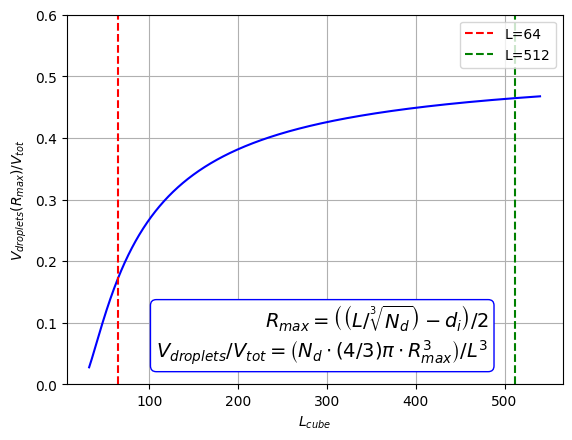

In [38]:
# volume sfere / volume cubo tot
C = np.pi*4.0/3.0
interf = 2.5
n=64

def vol_ratio(R):
    return n*C*R**3 / (dim**3)

# volume n sfere a R_max / volume cubo tot
def max_vol_ratio(L):
    rmax = L/(2*np.cbrt(n)) - interf
    return n*C*rmax**3 / (L**3)

# questo e' per vedere un singolo caso: come varia il volume ratio cambiando il raggio delle sfere?
# dim=512
# Rmax=dim/(2*np.cbrt(n))-interf
# start = 20
# end = 80
# r = np.linspace(start,end,1000)
# _ = plt.figure(1)
# _ = plt.plot(r,vol_ratio(r),"blue")
# _ = plt.hlines(vol_ratio(Rmax), start, end, "red", "--")
# _ = plt.vlines(Rmax, 0, 1, "green", "--")
# _ = plt.xlabel(r"$R_{droplets}$")
# _ = plt.ylabel(r"$V_{droplets}/V_{tot}$")
# _ = plt.grid()
# _ = plt.ylim([0,1.0])
# _ = plt.title(r"$L_{cube}=$%d, $n_{droplets}$=%d"%(dim,n))

# questo invece mostra il max volume ratio (da R_max) per ogni possibile L_cube
start = 32
end = 540
dims = np.linspace(start,end,1000)
_ = plt.figure(2)
_ = plt.plot(dims,max_vol_ratio(dims), "blue")
_ = plt.vlines(64, 0, 0.6, "red", "--", label="L=64" )
_ = plt.vlines(512, 0, 0.6, "green", "--", label="L=512" )
_ = plt.xlabel(r"$L_{cube}$")
_ = plt.ylabel(r"$V_{droplets}(R_{max})/V_{tot}$")
_ = plt.grid()
_ = plt.ylim([0,0.6])
_ = plt.legend()
equation = r"$R_{max} = \left(\left(L / \sqrt[3]{N_d}\right) - d_i\right) / 2$" + "\n" + r"$V_{droplets}/V_{tot} = \left(N_d\cdot (4/3)\pi\cdot R_{max}^3\right)/L^3$"
box = dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3')
_ = plt.text(0.85, 0.05, equation, verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=14, color='black', bbox=box)

In [19]:
direc = "/home/matti/DATA/Mayonese/staggered_run/"
dt = 500
start_move = 30000

def find_push(f):
    change_indices = np.where(np.diff(f) != 0)[0] + 1
    segment_indices = np.concatenate(([0], change_indices, [len(f)]))
    result = []
    for i in range(len(segment_indices) - 1):
        value = f[segment_indices[i]]
        start_idx = segment_indices[i]
        end_idx = segment_indices[i + 1] - 1
        result.append([value, start_idx, end_idx+2])
    return np.array(result)
name  = "output.csv"
head  = np.genfromtxt(direc+name, delimiter=',\t', dtype=str,   max_rows=1)
A     = np.genfromtxt(direc+name, delimiter=',\t', dtype=float, skip_header=True)
ps    = find_push(A[:, 3])
print(f"header = {head}")
print(f"pushing factor = {ps}")

name  = "avgz.out"
avgz  = np.loadtxt(direc+name)
first_out_shear = int(start_move / dt)
number_out = int(A[-1,0]/dt)


# primo e secondo elemento: step e number_droplets
# terzo e quarto elemento: avarage volume e total volume (ask girotto) ???
# il resto sono vol e surf delle droplets
def read_nonunif_col(f):
    first_two_columns = []
    second_two_columns = []
    matrix_data = []
    with open(f, 'r') as file:
        for line in file:
            elements = line.split()
            first_two_columns.append([int(elements[0]), int(elements[1])])
            second_two_columns.append([float(elements[2]), float(elements[3])]) 
            data = list(map(float, elements[4:]))
            matrix_data.append(data)
    max_length = max(len(row) for row in matrix_data)
    matrix_data_padded = np.array([row + [0] * (max_length - len(row)) for row in matrix_data])
    matrix_data_padded = ((4.0/(3.0*np.pi))*matrix_data_padded)**(1.0/3.0)# from volume to radius
    return np.array(first_two_columns).T, matrix_data_padded, np.array(second_two_columns).T
def binning(d, info, b):
    max_drop_idx = np.argmax(info[1,:])
    max_d = max(d[max_drop_idx,:])+1; #max_d = ;
    min_d = min(d[max_drop_idx,:])-1; #min_d = 1e5;
    bins = np.logspace(np.log10(min_d), np.log10(max_d), num=b)
    #bins = np.linspace(min_d, max_d, num=b)
    all_count = []; all_bin_edges = []; all_bin_centers = []
    size = len(d[:,0])
    for i in range(size):
        count, bin_edges = np.histogram(d[i,:], bins=bins)
        all_count.append(count); all_bin_edges.append(bin_edges)
        all_bin_centers.append(np.array([(all_bin_edges[i][j]+all_bin_edges[i][j+1])*0.5 for j in range(b-1)]))
    return np.array(all_count), np.array(all_bin_edges), np.array(all_bin_centers)
name = "droplets_volume_rho1.dat"
step_e_num, d_vol, avg_e_tot_vol = read_nonunif_col(direc+name)
name = "droplets_surface_rho1.dat"
step_e_num, d_sur, avg_e_tot_vol = read_nonunif_col(direc+name)
B = 30
count_vol, bin_edges_vol, bin_centers_vol = binning(d_vol, step_e_num, B)
count_sur, bin_edges_sur, bin_centers_sur = binning(d_sur, step_e_num, B)

header = ['Step' 'N_Drop' 'Vd/Vt' 'Push']
pushing factor = [[1.000e-04 0.000e+00 8.000e+00]
 [0.000e+00 7.000e+00 2.100e+01]
 [2.000e-05 2.000e+01 2.900e+01]
 [0.000e+00 2.800e+01 7.010e+02]
 [1.000e-06 7.000e+02 7.610e+02]
 [1.000e-05 7.600e+02 7.850e+02]
 [0.000e+00 7.840e+02 1.461e+03]]


m scale : [1.         0.45124787 0.         0.        ]
RR = [ 29500  51500  73500  95500 117500 139500]
RR = [ 29500  51500  73500  95500 117500 139500]
RR = [     0  19500  39500  59500  79500  99500 119500 139500]


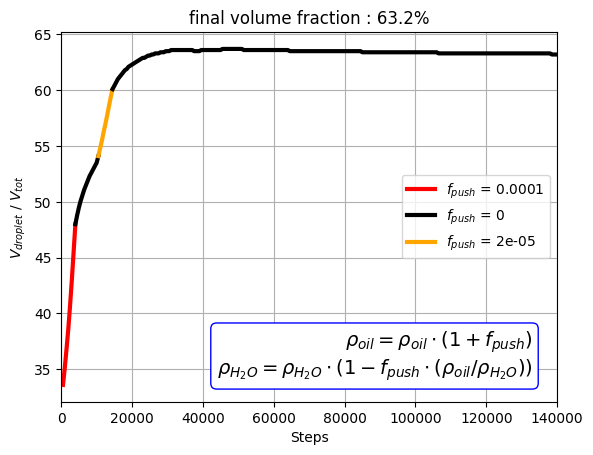

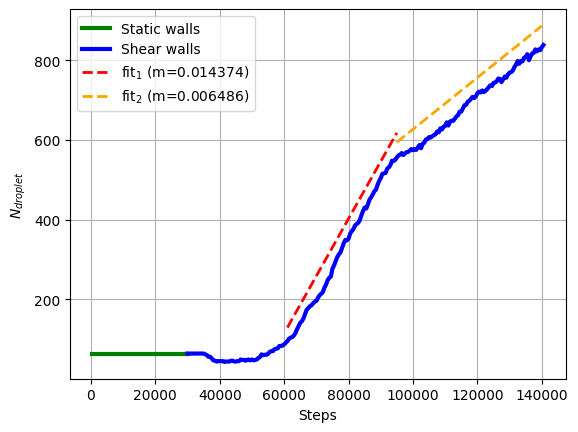

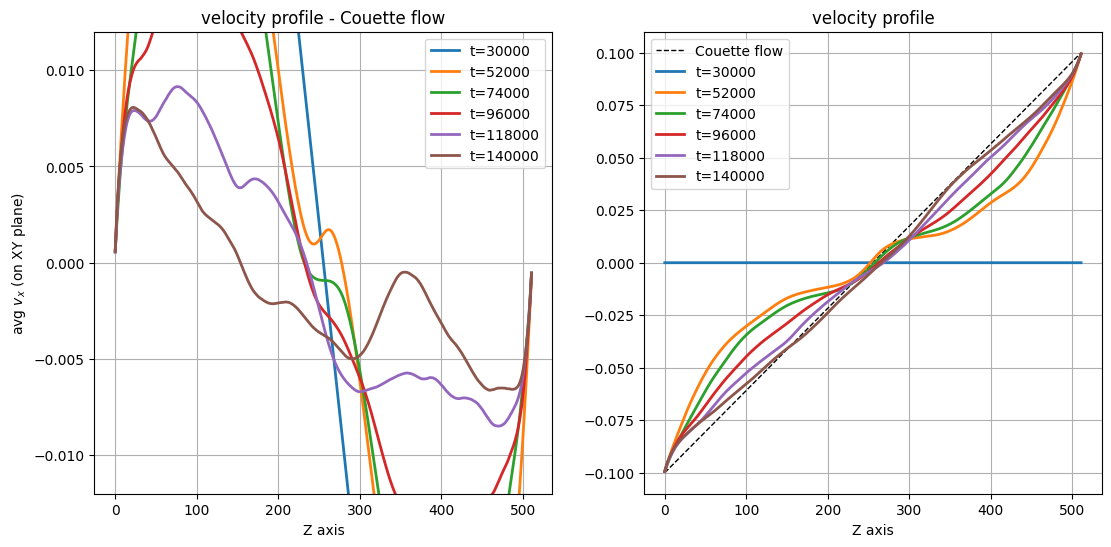

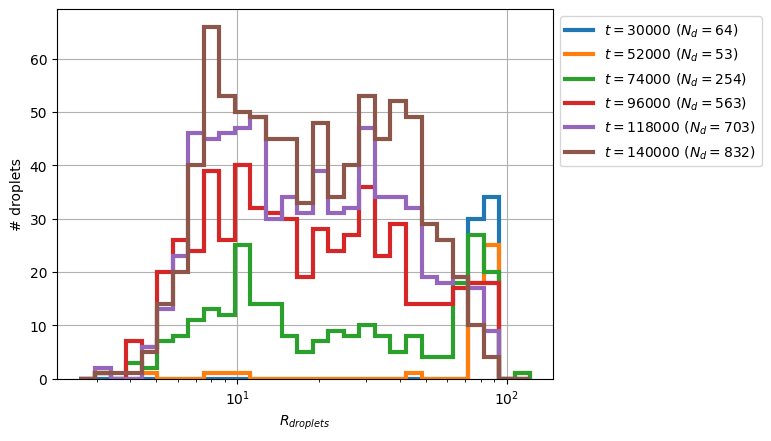

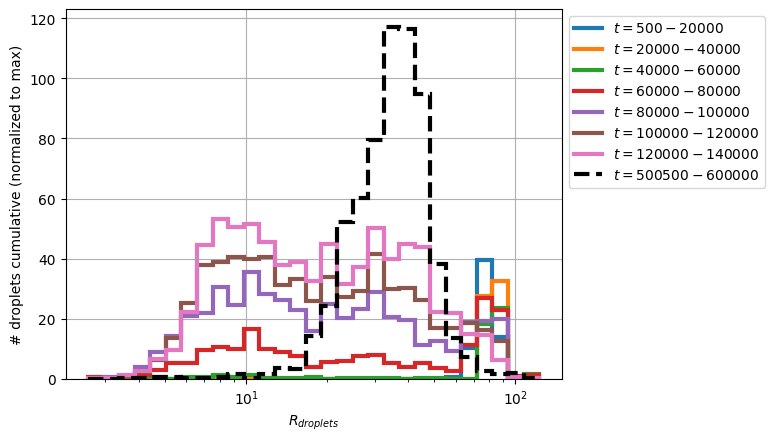

In [26]:
LIM = number_out * dt
LIM = 140000

SAVE = 1
save_dir = '/home/matti/Pictures/images/'

#evolution of volume fraction
def pp(f, p, col, L=True):
    idx_s = int(p[1])
    idx_e = int(p[2])
    if L: lab = '$f_{push}$ = %1.1g'%(p[0]); 
    else: lab = ""
    _ = plt.plot(f[idx_s:idx_e,0], f[idx_s:idx_e,2], color=col, linewidth=3, label=lab)
f1 = plt.figure(1)
idx=0
pp(A, ps[idx,:], "red"); idx+=1
pp(A, ps[idx,:], "black"); idx+=1
pp(A, ps[idx,:], "orange"); idx+=1
pp(A, ps[idx,:], "black", False); idx+=1
# pp(A, ps[idx,:], "green"); idx+=1
# pp(A, ps[idx,:], "lime"); idx+=1
# pp(A, ps[idx,:], "black", False); idx+=1
_ = plt.rc('axes', axisbelow=True)
_ = plt.grid()
_ = plt.xlabel("Steps")
_ = plt.ylabel("$V_{droplet}$ / $V_{tot}$")
_ = plt.title(r"final volume fraction : %1.1f%%"%(A[int(LIM/dt),2]))
_ = plt.xlim(0,LIM)
equation = r"$\rho_{oil} = \rho_{oil}\cdot(1+f_{push})$" + "\n" + r"$\rho_{H_2O} = \rho_{H_2O}\cdot(1-f_{push}\cdot(\rho_{oil}/\rho_{H_2O}))$"
box = dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3')
#_ = plt.text(0.05, 0.80, equation, verticalalignment='bottom', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=14, color='black', bbox=box)
_ = plt.text(0.95, 0.05, equation, verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=14, color='black', bbox=box)
_ = plt.legend()
if SAVE:
    _ = plt.savefig(save_dir+"v_frac.png", bbox_inches='tight', dpi=300, format='png')


#evolution of total number of droplets
def ppN(f, start, stop, name, col):
    mask = ( (f[:,0]<=stop) & (f[:,0]>=start) )
    _ = plt.plot(f[mask,0], f[mask,1], color=col, linewidth=3, label=name)
def plot_lin_fit(f, start, stop, name, col):
    mask = ( (f[:,0]<=stop) & (f[:,0]>=start) )
    m, q = np.polyfit(f[mask,0],f[mask,1],1)
    lab = " (m=%1.6f)"%(m); labtot = " (m=%1.6f, q=%1.1f)"%(m,q)
    _ = plt.plot(f[mask,0], m*f[mask,0]+q+50, color=col, linewidth=2, linestyle="--", label=name+lab)
    return m
f2 = plt.figure(2)
end = A[int(LIM/dt),0]
ppN(A, 0, start_move, "Static walls", "green")
ppN(A, start_move, end, "Shear walls", "blue")
FITS=1
if FITS:
    m = np.zeros((4))
    m[0] = plot_lin_fit(A,61000,95000,"fit$_1$","red")
    m[1] = plot_lin_fit(A,95000,140000,"fit$_2$","orange")
    # m[2] = plot_lin_fit(A,140000,210000,"fit$_3$","magenta")
    # m[3] = plot_lin_fit(A,211000,350000,"fit$_4$","lime")
    print(f"m scale : {m/m[0]}")
_ = plt.plot()
_ = plt.rc('axes', axisbelow=True)
_ = plt.legend()#loc='upper left', bbox_to_anchor=(1, 1))
_ = plt.grid()
_ = plt.xlabel("Steps")
_ = plt.ylabel("$N_{droplet}$")
if SAVE:
    _ = plt.savefig(save_dir+"N_drop.png", bbox_inches='tight', dpi=300, format='png')


# velocity_x profile along Z
number_lines = 6;
RR = np.linspace(first_out_shear-1,(LIM/dt)-1,number_lines).astype(int); print(f"RR = {RR*dt}")
f3 = plt.figure(3,  figsize=[13,6])
gs3 = f3.add_gridspec(1,2)
axs3 = gs3.subplots()
l = np.linspace(0,511,512)
lv = np.linspace(-0.1,+0.1,512)
#_ = plt.plot(l,lv,color='black', linestyle='--',linewidth=1, label="Couette flow")
for i in RR:
    _ = axs3[0].plot(avgz[i,:] - lv, linewidth=2, label="t=%d"%((i+1)*dt))
_ = axs3[0].legend()
_ = axs3[0].grid()
_ = axs3[0].set_ylim([-0.012,+0.012])
_ = axs3[0].set_title("velocity profile - Couette flow")
_ = axs3[0].set_xlabel("Z axis")
_ = axs3[0].set_ylabel("avg $v_x$ (on XY plane)")
_ = axs3[1].plot(l,lv,color='black', linestyle='--',linewidth=1, label="Couette flow")
for i in RR:
    _ = axs3[1].plot(avgz[i,:], linewidth=2, label="t=%d"%((i+1)*dt))
_ = axs3[1].legend()
_ = axs3[1].grid()
_ = axs3[1].set_title("velocity profile")
_ = axs3[1].set_xlabel("Z axis")
if SAVE:
    _ = plt.savefig(save_dir+"v_prof.png", bbox_inches='tight', dpi=300, format='png')



# distribution of droplets volume at each steps
number_lines = 6;
RR = np.linspace(first_out_shear-1,(LIM/dt)-1,number_lines).astype(int); print(f"RR = {RR*dt}")
#max_pick = np.max(count_vol)
max_pick = 1
f4 = plt.figure(4)
for i in RR:
    _ = plt.stairs(count_vol[i,:]/max_pick, bin_edges_vol[i,:], linewidth=3, label="$t=%d$ $(N_{d}=%d)$"%(step_e_num[0,i],step_e_num[1,i]))
    #_ = plt.plot(bin_centers_vol[i,:], count_vol[i,:]/max_pick, linewidth=2, label="$t=%d$ $(N_{d}=%d)$"%(step_e_num[0,i],step_e_num[1,i]))
_ = plt.xscale('log')
_ = plt.xlabel('$R_{droplets}$')
_ = plt.ylabel('# droplets');# (normalized to max)')
_ = plt.rc('axes', axisbelow=True)
_ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
_ = plt.grid(True)
if SAVE:
    _ = plt.savefig(save_dir+"R_distr.png", bbox_inches='tight', dpi=300, format='png')


# distribution of droplets volume cumulative on multiple steps
number_lines = 8;
RR = np.linspace(0,(LIM/dt)-1,number_lines).astype(int); print(f"RR = {RR*dt}")
f5 = plt.figure(5)
for i in range(len(RR)-1):
    i_s = RR[i]
    i_e = RR[i+1]
    norm=1/((i_e-i_s)*max_pick)
    _ = plt.stairs(np.sum(count_vol[i_s:i_e,:], axis=0)*norm, bin_edges_vol[i_e,:], linewidth=3, label="$t=%d-%d$"%(step_e_num[0,i_s],step_e_num[0,i_e]))
    #_ = plt.plot(bin_centers_vol[i_e,:], np.sum(count_vol[i_s:i_e,:], axis=0)*norm, linewidth=2, label="$t=%d-%d$"%(step_e_num[0,i_s],step_e_num[0,i_e]))
i_s = int(500000/dt); i_e = int(599500/dt); norm=1/((i_e-i_s)*max_pick)
_ = plt.stairs(np.sum(count_vol[i_s:i_e,:], axis=0)*norm, bin_edges_vol[i_e,:], color='black', linestyle='--', linewidth=3, label="$t=%d-%d$"%(step_e_num[0,i_s],step_e_num[0,i_e]))
_ = plt.xscale('log')
_ = plt.xlabel('$R_{droplets}$')
_ = plt.ylabel('# droplets cumulative (normalized to max)')
_ = plt.rc('axes', axisbelow=True)
_ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
_ = plt.grid(True)
if SAVE:
    _ = plt.savefig(save_dir+"R_distr_cumulative.png", bbox_inches='tight', dpi=300, format='png')